In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jpholiday

In [13]:
df = pd.read_excel('/Users/hiraokatatsuru/Library/CloudStorage/OneDrive-個人用/ドキュメント/物数データ.xlsx')
df.set_index('date', inplace=True)

In [14]:
def assign_season(date):
    if date.month in [3, 4, 5]:
        return 1  # 春
    elif date.month in [6, 7, 8]:
        return 2  # 夏
    elif date.month in [9, 10, 11]:
        return 3  # 秋
    else:
        return 4  # 冬

In [15]:
def generate_features(df, dates, feature_columns):
    idx    = df.index.union(dates)
    df_ext = df.reindex(idx)

    # 曜日系
    df_ext['dow']     = df_ext.index.dayofweek
    df_ext['dow_sin'] = np.sin(2*np.pi*df_ext['dow']/7)
    df_ext['dow_cos'] = np.cos(2*np.pi*df_ext['dow']/7)

    # 祝日系
    df_ext['is_holiday']             = df_ext.index.to_series().apply(jpholiday.is_holiday).astype(int)
    df_ext['is_after_holiday']       = df_ext['is_holiday'].shift(1).fillna(0).astype(int)
    df_ext['is_after_after_holiday'] = df_ext['is_holiday'].shift(2).fillna(0).astype(int)

    # 月・年末年始・お盆
    df_ext['month']       = df_ext.index.month
    df_ext['season'] = df_ext.index.map(assign_season)
    df_ext['is_new_year'] = ((df_ext.index.month == 1) & (df_ext.index.day <= 3)).astype(int)
    df_ext['is_obon']     = (
        (df_ext.index.month == 8) &
        (df_ext.index.day   >= 13) &
        (df_ext.index.day   <= 16)
    ).astype(int)

    # ラグ・移動平均
    df_ext['lag_1']          = df_ext['通常物数'].shift(1)
    df_ext['lag_7']          = df_ext['通常物数'].shift(7)
    df_ext['rolling_mean_7'] = df_ext['通常物数'].shift(1).rolling(7).mean()

    # 価格増加フラグ
    df_ext['price_increase_flag'] = 0
    df_ext.loc[df_ext.index >= pd.Timestamp('2024-10-01'), 'price_increase_flag'] = 1

    # 最終的に欲しい行・列を抽出
    return df_ext.loc[dates, feature_columns]


CV MAE: 4574.55 ± 787.67
CV RMSE: 8317.04 ± 1695.72

===== Cross-Validation Result (TimeSeriesSplit) =====
Average MAE : 4574.55
Average RMSE: 8317.04


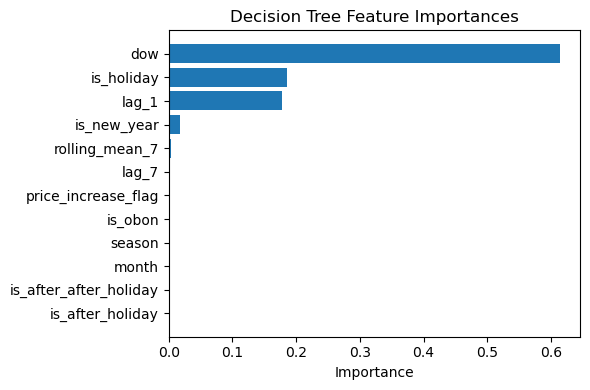

            predicted_通常物数
date                      
2025-06-01             0.0
2025-06-02         81020.0
2025-06-03         87760.0
2025-06-04         80530.0
2025-06-05         84065.0
2025-06-06         88350.0
2025-06-07             0.0
2025-06-08             0.0
2025-06-09         82220.0
2025-06-10         86780.0
2025-06-11         81460.0
2025-06-12         80820.0
2025-06-13         80955.0
2025-06-14             0.0
2025-06-15             0.0
2025-06-16         82220.0
2025-06-17         86780.0
2025-06-18         81460.0
2025-06-19         80820.0
2025-06-20         80955.0
2025-06-21             0.0
2025-06-22             0.0
2025-06-23         82220.0
2025-06-24         86780.0
2025-06-25         81460.0
2025-06-26         80820.0
2025-06-27         80955.0
2025-06-28             0.0


/var/folders/t3/j19g2ldj2ks74jzlzsqq83640000gn/T/ipykernel_21648/1245983314.py:90: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_future = X_future.fillna(method='ffill')  # もし先頭に NaN があれば前日値で埋める


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. データ準備 --------------------------------------------------

# 元データ df （インデックスが日付、"通常物数" 列が目的変数）
# 予測対象の日時リスト dates_all
# 学習に使う特徴量列リスト feature_columns

# 例:
# dates_all = pd.date_range(start='2023-01-01', end='2025-03-31', freq='D')
feature_columns = [#'dow_sin','dow_cos',
    'dow',
    'is_holiday','is_after_holiday','is_after_after_holiday',
    'month','season','lag_1','lag_7','rolling_mean_7','is_new_year','is_obon','price_increase_flag'
]

X_all = generate_features(df, df.index, feature_columns)
# 3. 目的変数を揃える
y_all = df['通常物数'].loc[X_all.index]

# 4. 欠損行（ラグ計算で NaN が出る最初の数行）を削除
mask   = X_all.isnull().any(axis=1)
X_all  = X_all.loc[~mask]
y_all  = y_all.loc[~mask]


# --- 2. 時系列分割による交差検証 ---------------------------------------

tscv = TimeSeriesSplit(n_splits=5)
mae_list, rmse_list = [], []

for train_idx, test_idx in tscv.split(X_all):
    X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
    y_train, y_test = y_all.iloc[train_idx], y_all.iloc[test_idx]

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print("CV MAE: {:.2f} ± {:.2f}".format(np.mean(mae_list), np.std(mae_list)))
print("CV RMSE: {:.2f} ± {:.2f}".format(np.mean(rmse_list), np.std(rmse_list)))

# ------------------------------------------------------------------------------
# 4. Cross-Validation 結果の平均を出力
# ------------------------------------------------------------------------------
print("\n===== Cross-Validation Result (TimeSeriesSplit) =====")
print(f"Average MAE : {np.mean(mae_list):.2f}")
print(f"Average RMSE: {np.mean(rmse_list):.2f}")

# ------------------------------------------------------------------------------
# 4. 特徴量重要度の可視化
# ------------------------------------------------------------------------------
importances = model_dt.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# --- 3. フルデータ学習 ------------------------------------------------

# 最終的に全データでモデルを再学習
final_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
final_model.fit(X_all, y_all)


# --- 4. 将来予測 ------------------------------------------------------

# 予測したい未来の日付リスト future_dates（例：2025-04-01 ～ 2025-04-28）
future_dates = pd.date_range(start='2025-06-01', periods=28, freq='D')
X_future = generate_features(df, future_dates, feature_columns)

# 必要なら直前までの df に future_dates をマージしておく
# （lag や rolling_mean が正しく計算されるように）
X_future = X_future.fillna(method='ffill')  # もし先頭に NaN があれば前日値で埋める

y_future_pred = final_model.predict(X_future)

# 結果を DataFrame にまとめ
forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_通常物数': y_future_pred
}).set_index('date')

print(forecast_df)


In [39]:
preds = pd.Series(index=future_dates, dtype=float)
history = df['通常物数'].copy()  # 元データ＋予測値を随時追加

for dt in future_dates:
    # ── 1) 当日 dt の特徴量を generate_features で作成 ──
    # history を DataFrame に変換して渡す
    hist_df = history.to_frame(name='通常物数')
    X_dt = generate_features(
        hist_df,
        [dt],                # その日のみ
        feature_columns
    ).iloc[0:1]             # 1行の DataFrame

    # ── 2) 予測＆繰り越しロジック ──
    raw = final_model.predict(X_dt)[0]
    is_wh = jpholiday.is_holiday(dt) or dt.weekday() >= 5
    if is_wh:
        carry += raw
        pred = 0.0
    else:
        pred = raw + carry
        carry = 0.0

    # ── 3) 結果を保存 ──
    preds[dt]       = pred
    history[dt]     = pred      # 次日の lag に使うために追加

# ── 4. DataFrame にまとめ ──
future_df = preds.to_frame(name='通常物数')

# ── 5. 曜日・祝日列を追加（表示に使うだけ）──
future_df['weekday']    = future_df.index.dayofweek
future_df['is_holiday'] = future_df.index.to_series().apply(jpholiday.is_holiday).astype(int)

# ── 6. 千通単位で四捨五入 ──
future_df['通常物数'] = future_df['通常物数'].round(-3).astype(int)

# ── 7. 行ごとに成型して出力 ──
weekday_map = ['月','火','水','木','金','土','日']
for date, row in future_df.iterrows():
    wd = weekday_map[row['weekday']]
    hk = '祝' if row['is_holiday'] else ''
    print(f"{date.strftime('%Y-%m-%d')} ({wd}{hk}): {row['通常物数']} 通")

# ── 8. 必要なら future_df を返す / 保存する ──


2025-06-01 (日): 0 通
2025-06-02 (月): 81000 通
2025-06-03 (火): 30000 通
2025-06-04 (水): 35000 通
2025-06-05 (木): 38000 通
2025-06-06 (金): 39000 通
2025-06-07 (土): 0 通
2025-06-08 (日): 0 通
2025-06-09 (月): 86000 通
2025-06-10 (火): 29000 通
2025-06-11 (水): 33000 通
2025-06-12 (木): 39000 通
2025-06-13 (金): 43000 通
2025-06-14 (土): 0 通
2025-06-15 (日): 0 通
2025-06-16 (月): 82000 通
2025-06-17 (火): 29000 通
2025-06-18 (水): 33000 通
2025-06-19 (木): 39000 通
2025-06-20 (金): 43000 通
2025-06-21 (土): 0 通
2025-06-22 (日): 0 通
2025-06-23 (月): 87000 通
2025-06-24 (火): 30000 通
2025-06-25 (水): 35000 通
2025-06-26 (木): 39000 通
2025-06-27 (金): 43000 通
2025-06-28 (土): 0 通


In [31]:
def backtest_recursive(df, horizon, model, feature_columns):
    hist = df['通常物数'][:-horizon].copy()
    preds = []
    carry = 0.0
    for dt in df.index[-horizon:]:
        X_dt = generate_features(hist.to_frame(), [dt], feature_columns)
        raw = final_model.predict(X_dt)[0]
        is_wh = jpholiday.is_holiday(dt) or dt.weekday()>=5
        if is_wh:
            carry += raw
            pred = 0.0
        else:
            pred = raw + carry
            carry = 0.0
        preds.append(pred)
        hist[dt] = pred  # or 実績値にしてもOK
    actual = df['通常物数'].iloc[-horizon:]
    return mean_absolute_error(actual, preds), np.sqrt(mean_squared_error(actual, preds))

mae, rmse = backtest_recursive(df, 28, final_model, feature_columns)
print(f"Backtest MAE={mae:.0f}, RMSE={rmse:.0f}")


Backtest MAE=5003, RMSE=7248


In [32]:
def backtest_with_blending(df, horizon, model, feature_columns, alphas):
    results = []
    for α in alphas:
        hist = df['通常物数'][:-horizon].copy()
        carry = 0.0
        preds = []
        for dt in df.index[-horizon:]:
            X_dt = generate_features(hist.to_frame(), [dt], feature_columns)
            raw = final_model.predict(X_dt)[0]
            is_wh = jpholiday.is_holiday(dt) or dt.weekday() >= 5
            if is_wh:
                carry += raw
                pred = 0.0
            else:
                pred = raw + carry
                carry = 0.0
            # ブレンド
            last_true = hist.iloc[-1]
            blended = α * pred + (1 - α) * last_true
            preds.append(blended)
            hist[dt] = blended
        actual = df['通常物数'].iloc[-horizon:]
        mae = mean_absolute_error(actual, preds)
        rmse = np.sqrt(mean_squared_error(actual, preds))
        results.append((α, mae, rmse))
    return pd.DataFrame(results, columns=['alpha','MAE','RMSE']).set_index('alpha')

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
blend_df = backtest_with_blending(df, 28, final_model, feature_columns, alphas)
print(blend_df)


                MAE          RMSE
alpha                            
0.00   29214.285714  40329.889660
0.25   19823.299794  27890.101045
0.50   16605.004733  24631.633969
0.75   13476.026685  16476.749552
1.00    5003.392857   7248.213142
